## Overview

We would like to get a database with an history of the average temperature per day in the main world cities. We would use the geobases database to get a list of cities and the climate data in the daily GHCN database.
Therefore, we will extract the nearest weather station WITH temperature data to a city in the geobases list.

In [1]:
import pandas as pd

In [2]:
# Load of geobase
from GeoBases import GeoBase
geo_c = GeoBase(data='ori_por', verbose=False)

## Load and parsing of stations data

We load the stations data description and extract the information we need: id, coordinates and city name

In [3]:
#List of stations
!cat stations.txt | head -n 10

ACW00011604  17.1167  -61.7833   10.1    ST JOHNS COOLIDGE FLD                       
ACW00011647  17.1333  -61.7833   19.2    ST JOHNS                                    
AE000041196  25.3330   55.5170   34.0    SHARJAH INTER. AIRP            GSN     41196
AEM00041194  25.2550   55.3640   10.4    DUBAI INTL                             41194
AEM00041217  24.4330   54.6510   26.8    ABU DHABI INTL                         41217
AEM00041218  24.2620   55.6090  264.9    AL AIN INTL                            41218
AF000040930  35.3170   69.0170 3366.0    NORTH-SALANG                   GSN     40930
AFM00040938  34.2100   62.2280  977.2    HERAT                                  40938
AFM00040948  34.5660   69.2120 1791.3    KABUL INTL                             40948
AFM00040990  31.5000   65.8500 1010.0    KANDAHAR AIRPORT                       40990
cat: write error: Broken pipe


In [4]:
stationstxt = ""
with open("stations.txt") as input:
    stationstxt = input.read()

In [5]:
#Extract the data from file
stations = stationstxt.split("\n")

#Remove last line
stations = stations[:-1]

stations = map(lambda line: [line[0:11],float(line[13:20]),float(line[22:30]),line[41:71]], stations)

In [6]:
len(stations)

100198

In [7]:
stations[:5]

[['ACW00011604', 17.1167, -61.7833, 'ST JOHNS COOLIDGE FLD         '],
 ['ACW00011647', 17.1333, -61.7833, 'ST JOHNS                      '],
 ['AE000041196', 25.333, 55.517, 'SHARJAH INTER. AIRP           '],
 ['AEM00041194', 25.255, 55.364, 'DUBAI INTL                    '],
 ['AEM00041217', 24.433, 54.651, 'ABU DHABI INTL                ']]

## Selection of stations with temperature data

We read the climate data file, select only the lines with temperature data TAVG and extract the list of stations.

In [8]:
!cat 2016.csv | head -n 10

US1FLSL0019,20160101,PRCP,3,,,N,
USC00141761,20160101,TMAX,22,,,H,0700
USC00141761,20160101,TMIN,-89,,,H,0700
USC00141761,20160101,TOBS,-89,,,H,0700
USC00141761,20160101,PRCP,0,,,H,0700
USC00141761,20160101,SNOW,0,,,H,
USC00141761,20160101,SNWD,0,,,H,0700
USS0018D08S,20160101,TMAX,-25,,,T,
USS0018D08S,20160101,TMIN,-177,,,T,
USS0018D08S,20160101,TOBS,-61,,,T,
cat: write error: Broken pipe


In [9]:
weatherdf = pd.read_csv("2016.csv",header=None)
weatherdf.columns = ["id","date","type","Value1","Value2","Value3","Value4","Value5"]
weatherdf.head()

,id,date,type,Value1,Value2,Value3,Value4,Value5
0,US1FLSL0019,20160101,PRCP,3,NaN,NaN,N,NaN
1,USC00141761,20160101,TMAX,22,NaN,NaN,H,700
2,USC00141761,20160101,TMIN,-89,NaN,NaN,H,700
3,USC00141761,20160101,TOBS,-89,NaN,NaN,H,700
4,USC00141761,20160101,PRCP,0,NaN,NaN,H,700


In [10]:
#Get total number of days
days = len(weatherdf.groupby("date").groups.keys())
days

51

In [11]:
#Check all the types of measures that are done
print weatherdf.groupby("type").groups.keys()

['TSUN', 'TMIN', 'DATX', 'SN52', 'SN53', 'MNPN', 'WDFG', 'SX36', 'DATN', 'SNWD', 'PGTM', 'WT11', 'SN51', 'SX53', 'SX32', 'MDTX', 'DAPR', 'SX52', 'WT08', 'SX51', 'WT05', 'WT04', 'WSF2', 'WT06', 'WT01', 'WSF5', 'WT03', 'WT02', 'WSFI', 'SX35', 'SX31', 'TOBS', 'SX33', 'EVAP', 'SN33', 'WT09', 'MXPN', 'WSFG', 'MDTN', 'DWPR', 'AWND', 'WESD', 'THIC', 'WT07', 'TAVG', 'PSUN', 'PRCP', 'TMAX', 'SNOW', 'MDPR', 'SN36', 'SN35', 'SN32', 'WDF5', 'SN31', 'WDMV', 'WDF2', 'WESF', 'AWDR']


In [12]:
#Let's create a list of stations with the TAVG data
stationstavg = weatherdf[weatherdf["type"]=="TAVG"].groupby("id")["date"].count()

In [13]:
len(stationstavg)

5862

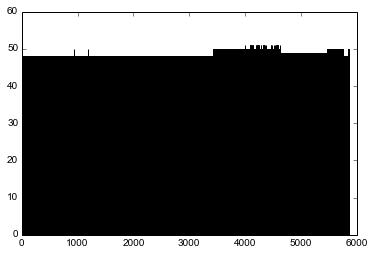

In [14]:
#We visualize the days covered by the station with temperature data
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(len(stationstavg)),stationstavg)
plt.show()

In [15]:
stationstavg = stationstavg[stationstavg>45].reset_index()

# Merge of the stations list with the temperature stations to get info on the temperature stations

In [16]:
#We filter the stations and only take the ones with tavg
stationsdf = pd.DataFrame(stations)
stationsdf.columns = ["id","lat","lng","name"]
print(len(stationsdf))
stationsdf = stationsdf.merge(stationstavg,on="id")[["id","lat","lng","name"]]
print(len(stationsdf))
stations = stationsdf.values.tolist()

100198
5422


## Find the nearest city to each weather station (10km radius)

In [17]:
def getCity(lat,lng):
    try:
        l = [[k,int("0"+geo_c.get(k)["population"])] for _,k in geo_c.findNearPoint((lat, lng), 10)]
        l = sorted(l, key=lambda city: city[1], reverse=True)[0]
        code = l[0]
        return geo_c.get(code,'city_code')
    except:
        return ""

stations = map(lambda s: s + [getCity(s[1],s[2])],stations)

In [18]:
stations[:5]

[['AE000041196', 25.333, 55.517, 'SHARJAH INTER. AIRP           ', 'SHJ'],
 ['AEM00041194', 25.255, 55.364, 'DUBAI INTL                    ', 'DXB'],
 ['AEM00041217', 24.433, 54.651, 'ABU DHABI INTL                ', 'AUH'],
 ['AEM00041218', 24.262, 55.609, 'AL AIN INTL                   ', 'AAN'],
 ['AFM00040938', 34.21, 62.228, 'HERAT                         ', 'HEA']]

In [19]:
stationsdf = pd.DataFrame(stations)
stationsdf.columns = ["id","lat","lng","name","asciicity"]

In [20]:
#We take only the stations near a city
stationswithcity = stationsdf[stationsdf["asciicity"]!=""]

In [21]:
len(stationsdf)

5422

In [22]:
len(stationswithcity)

1521

In [23]:
citiesdf = stationswithcity.groupby("asciicity").first().reset_index()

In [24]:
#Number of cities with one or several weather stations
len(citiesdf)

1435

In [25]:
#We write the result to a csv
open("citiesweather.csv","w").write(citiesdf.to_csv())

In [26]:
#Example with Madrid
citiesdf[citiesdf["asciicity"].str.contains("MAD")]

,asciicity,id,lat,lng,name
704,MAD,SPE00120278,40.4667,-3.5556,MADRID/BARAJAS


In [27]:
citiesdf.sample(5)

,asciicity,id,lat,lng,name
1069,SJO,CSM00078762,9.9940,-84.2090,JUAN SANTAMARIA INTL
1033,SBW,MYM00096421,2.2620,111.9850,SIBU
1126,SYM,CHM00056964,22.7670,100.9830,SIMAO
266,DBQ,USW00094908,42.3978,-90.7036,DUBUQUE RGNL AP
565,KEJ,RSM00029642,55.2700,86.1070,KEMEROVO


# Now we can extract the temperature data for any city by its iata code

In [28]:
#First we find the id of the station assigend to Madrid
code = citiesdf[citiesdf["asciicity"]=="BCN"]["id"].values[0]
code

'SP000008181'

In [29]:
#Now we extract the data from the climate table
datatavg = weatherdf[(weatherdf["id"]==code)&(weatherdf["type"]=="TAVG")].sort_values("date")
datatavg["Value1"]=datatavg["Value1"]/10
datatavg = datatavg.reset_index()
datatavg.sample(5)

,index,id,date,type,Value1,Value2,Value3,Value4,Value5
43,3161565,SP000008181,20160213,TAVG,17.2,H,NaN,S,NaN
18,1381035,SP000008181,20160119,TAVG,8.5,H,NaN,S,NaN
9,708497,SP000008181,20160110,TAVG,15.3,H,NaN,S,NaN
5,408635,SP000008181,20160106,TAVG,10.9,H,NaN,S,NaN
45,3291641,SP000008181,20160215,TAVG,9.7,H,NaN,S,NaN


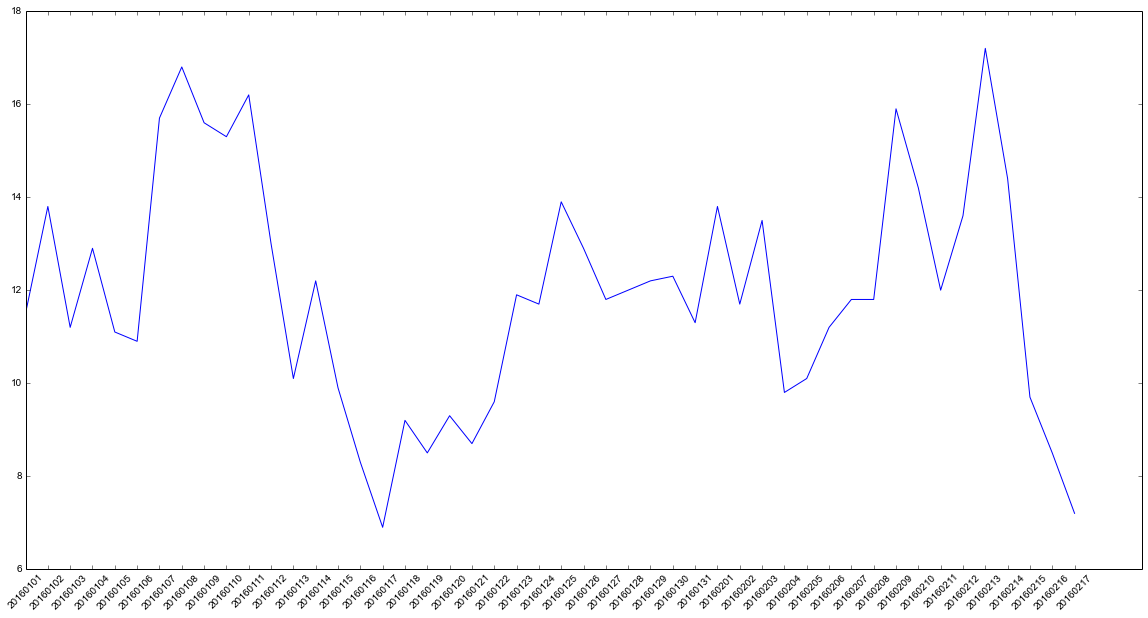

In [30]:
plt.figure(figsize=(20,10))
x = range(len(datatavg))
plt.plot(x,datatavg["Value1"])
plt.xticks(x, datatavg["date"], rotation='45')
plt.show()